## QM9 Dataset exploration

The purpose of this notebook is as follows,

 - Explain [QM9 dataset](http://quantum-machine.org/datasets/): Check the labels and visualization of molecules to understand what kind of data are stored.
 - Explain internal structure of QM9 dataset in `chainer_chemistry`: We handle the dataset with `NumpyTupleDataset`.
 - Explain how `preprocessor` and `parser` work on `chainer_chemistry`: One concrete example using `GGNNPreprocessor` is explained.

It is out of scope of this notebook to explain how to train graph convolutional network using this dataset, please refer [document tutorial](http://chainer-chemistry.readthedocs.io/en/latest/tutorial.html#) or try `train_qm9.py` in [QM9 example](https://github.com/pfnet-research/chainer-chemistry/tree/master/examples/qm9) for the model training.

[Note]
This notebook is executed on 27, Feb, 2018.
The behavior of QM9 dataset in `chainer_chemistry` might change in the future.

Loading modules and set loglevel.

In [1]:
import logging
from rdkit import RDLogger
from chainer_chemistry import datasets

# Disable errors by RDKit occurred in preprocessing Tox21 dataset.
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# show INFO level log from chainer chemistry
logging.basicConfig(level=logging.INFO)

QM9 dataset can be downloaded automatically by chainer chemistry. 
Original format of QM9 dataset is zipped file where each molecule's information is stored in each "xyz" file.

Chainer Chemistry automatically merge these information in one csv file internally, you may check the file path of this csv file with `get_qm9_filepath` method. 

In [8]:
dataset_filepath = datasets.get_qm9_filepath()

print('dataset_filepath =', dataset_filepath)

The dataset contains several chemical/physical properties. The labels of QM9 dataset can be checked by `get_qm9_label_names` method.

In [10]:
label_names = datasets.get_qm9_label_names()
print('QM9 label_names =', label_names)

QM9 label_names = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']


More detail information is described in `readme.txt` of QM9 dataset, which can be downloaded from 
 - [https://figshare.com/articles/Readme_file%3A_Data_description_for__Quantum_chemistry_structures_and_properties_of_134_kilo_molecules_/1057641](https://figshare.com/articles/Readme_file%3A_Data_description_for__Quantum_chemistry_structures_and_properties_of_134_kilo_molecules_/1057641)

Below is the description of each property(label), written in readme.txt

<a id='table1'></a>
<blockquote cite="https://figshare.com/articles/Readme_file%3A_Data_description_for__Quantum_chemistry_structures_and_properties_of_134_kilo_molecules_/1057641">
<pre>
I.  Property  Unit         Description
--  --------  -----------  --------------
 1  tag       -            "gdb9"; string constant to ease extraction via grep
 2  index     -            Consecutive, 1-based integer identifier of molecule
 3  A         GHz          Rotational constant A
 4  B         GHz          Rotational constant B
 5  C         GHz          Rotational constant C
 6  mu        Debye        Dipole moment
 7  alpha     Bohr^3       Isotropic polarizability
 8  homo      Hartree      Energy of Highest occupied molecular orbital (HOMO)
 9  lumo      Hartree      Energy of Lowest occupied molecular orbital (LUMO)
10  gap       Hartree      Gap, difference between LUMO and HOMO
11  r2        Bohr^2       Electronic spatial extent
12  zpve      Hartree      Zero point vibrational energy
13  U0        Hartree      Internal energy at 0 K
14  U         Hartree      Internal energy at 298.15 K
15  H         Hartree      Enthalpy at 298.15 K
16  G         Hartree      Free energy at 298.15 K
17  Cv        cal/(mol K)  Heat capacity at 298.15 K
</pre>
</blockquote>

### Preprocessing dataset

Dataset extraction depends on the preprocessing method, which is determined by `preprocessor`.

Here, let's look an example of using `GGNNPreprocessor` preprocessor for QM9 dataset extraction.

Procedure is as follows,

1. Instantiate `preprocessor` (here `GGNNPreprocessor` is used).
2. call `get_qm9` method with `preprocessor`.
 - `labels=None` option is used to extract all labels. In this case, 15 types of physical properties are extracted (see above).

Note that `return_smiles` option can be used to get SMILES information together with the dataset itself.

In [15]:
from chainer_chemistry.dataset.preprocessors.ggnn_preprocessor import \
    GGNNPreprocessor
    
preprocessor = GGNNPreprocessor()
dataset, dataset_smiles = datasets.get_qm9(preprocessor, labels=None, return_smiles=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133885/133885 [01:19<00:00, 1692.91it/s]
INFO:chainer_chemistry.dataset.parsers.csv_file_parser:Preprocess finished. FAIL 0, SUCCESS 133885, TOTAL 133885


## Check extracted dataset

First, let's check type and number of dataset.

In [16]:
print('dataset information...')
print('dataset', type(dataset), len(dataset))

print('smiles information...')
print('dataset_smiles', type(dataset_smiles), len(dataset_smiles))

dataset information...
dataset <class 'chainer_chemistry.datasets.numpy_tuple_dataset.NumpyTupleDataset'> 133885
smiles information...
dataset_smiles <class 'numpy.ndarray'> 133885


As you can see, QM9 dataset consists of 133885 data.

The dataset is a class of `NumpyTupleDataset`, where i-th dataset features can be accessed by `dataset[i]`.

When `GGNNPreprocessor` is used, each dataset consists of following features
 1. atom feature: representing atomic number of given molecule. 
 2. adjacency matrix feature: representing adjacency matrix of given molecule.
    `GGNNPreprocessor` extracts adjacency matrix of each bonding type.
 3. label feature: representing chemical properties (label) of given molecule.
    Please refer [above table](#table1) for details.

Let's look an example of 7777-th dataset

In [17]:
index = 7777

print('index={}, SMILES={}'.format(index, dataset_smiles[index]))
atom, adj, labels = dataset[index]
# This molecule has N=17 atoms.
print('atom', atom.shape, atom)
# adjacency matrix is NxN matrix, where N is number of atoms in the molecule.
# Unlike usual adjacency matrix, diagonal elements are filled with 1, for NFP calculation purpose.
print('adj', adj.shape)
print('adjacency matrix for SINGLE bond type\n', adj[0])
print('adjacency matrix for DOUBLE bond type\n', adj[1])
print('adjacency matrix for TRIPLE bond type\n', adj[2])
print('adjacency matrix for AROMATIC bond type\n', adj[3])

print('labels', labels)

index=7777, SMILES=CC1=NCCC(C)O1
atom (8,) [6 6 7 6 6 6 6 8]
adj (4, 8, 8)
adjacency matrix for SINGLE bond type
 [[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0.]]
adjacency matrix for DOUBLE bond type
 [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
adjacency matrix for TRIPLE bond type
 [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
adjacency matrix for AROMATIC bond type
 [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 

## Visualizing the molecule

One might want to visualize molecule given SMILES information. Here is an example code:

In [25]:
# This script is referred from http://rdkit.blogspot.jp/2015/02/new-drawing-code.html
# and http://cheminformist.itmol.com/TEST/wp-content/uploads/2015/07/rdkit_moldraw2d_2.html
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg

def render_svg(svg):
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return SVG(svg.replace('svg:',''))

smiles: CC1=NCCC(C)O1


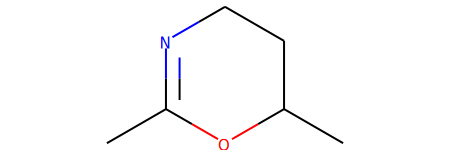

In [27]:
smiles = dataset_smiles[index]
mol = Chem.MolFromSmiles(dataset_smiles[index])

print('smiles:', smiles)
svg = moltosvg(mol)
render_svg(svg)

## Interactively watch through the QM9 dataset

Jupyter notebook provides handy module to check/visualize the data. Here interact module can be used to interactively check the internal of QM9 dataset.

index=98297, SMILES=CNC(=O)C(O)C1CN1
atom [6 7 6 8 6 8 6 6 7]
labels [   3.058    1.036    0.892    3.818   73.13    -0.242    0.016    0.258
 1362.772    0.159 -456.346 -456.336 -456.335 -456.381   34.466]


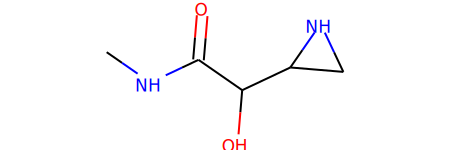

In [28]:
from ipywidgets import interact
import numpy as np
np.set_printoptions(precision=3, suppress=True)

def show_dataset(index):
    print('index={}, SMILES={}'.format(index, dataset_smiles[index]))
    atom, adj, labels = dataset[index]
    print('atom', atom)
    # print('adj', adj)
    print('labels', labels)
    mol = Chem.MolFromSmiles(dataset_smiles[index])
    return render_svg(moltosvg(mol))

interact(show_dataset, index=(0, len(dataset) - 1, 1))

## Appendix: how to save the molecule figure?


### 1. Save with SVG format

First method is simply save svg in file.

In [31]:
import os
dirpath = 'images'

if not os.path.exists(dirpath):
    os.mkdir(dirpath)

In [38]:
def save_svg(mol, filepath):
    svg = moltosvg(mol)
    with open(filepath, "w") as fw:
        fw.write(svg)

In [39]:
index = 7777
save_filepath = os.path.join(dirpath, 'mol_{}.svg'.format(index))
print('drawing {}'.format(save_filepath))

mol = Chem.MolFromSmiles(dataset_smiles[index])
save_svg(mol, save_filepath)

drawing images\mol_7777.svg


### 2. Save with png format

`rdkit` provides `Draw.MolToFile` method to visualize mol instance and save it to png format.

In [42]:
from rdkit.Chem import Draw

def save_png(mol, filepath, size=(600, 600)):
    Draw.MolToFile(mol, filepath, size=size)

In [43]:
from rdkit.Chem import Draw
index = 7777
save_filepath = os.path.join(dirpath, 'mol_{}.png'.format(index))
print('drawing {}'.format(save_filepath))

mol = Chem.MolFromSmiles(dataset_smiles[index])
save_png(mol, save_filepath, size=(600, 600))

drawing images\mol_7777.png
